In [9]:
!apt-get install libta-lib0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0


In [10]:
!pip install ta-lib

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
import talib # Für technische Indikatoren

# --- 1. Konfiguration ---
# Definiere das Epsilon, um die 'log(0)' Katastrophe zu verhindern.
EPSILON_FLOOR = 1e-6
LOOKBACK_WINDOW = 10 # L Tage für Features (z.B. Volatilität)
TRAIN_TEST_SPLIT_DATE = '2020-01-01' # Klare Trennung von Training und Evaluation

# --- WICHTIG: ANGEPASSTE PFADE ---
BASE_PATH = '/content/drive/MyDrive/01_Data/projects/PPO_portfolio_optimization/raw_data/'

# Input-Datei (Rohdaten)
RAW_DATA_FILE = os.path.join(BASE_PATH, 'sp500_20_years_data.csv')

# Output-Datei (Saubere Features für den Agenten)
CLEANED_FEATURES_FILE = os.path.join('/content/drive/MyDrive/01_Data/projects/PPO_portfolio_optimization/processed_data/', 'features_cleaned.csv')


# --- 2. Google Drive Mount & Laden der Rohdaten ---
try:
    drive.mount('/content/drive')

    # Stelle sicher, dass der Output-Pfad existiert
    os.makedirs(BASE_PATH, exist_ok=True)

    print(f"Lade Rohdaten von: {RAW_DATA_FILE}")
    # Annahme: Datei enthält MultiIndex-Daten von yfinance
    # mit 'Date' als erster Spalte, oberste Zeile als Metriken (Close, Open, etc.),
    # und zweite Zeile als Ticker Symbole.
    raw_data = pd.read_csv(RAW_DATA_FILE, header=[0, 1], index_col=0, parse_dates=True)

    # Benenne die MultiIndex-Levels für bessere Lesbarkeit und Zugriff
    raw_data.columns.names = ['Metric', 'Ticker']

    # Filtern der 'Close' Preise
    # Die Bedingung raw_data.columns.names wird jetzt korrekt geprüft.
    if 'Close' in raw_data.columns.get_level_values('Metric'):
        price_df = raw_data['Close']
    else:
        # Fallback, falls 'Close' nicht als oberste Metrik gefunden wird
        print("WARNUNG: 'Close' Metrik nicht gefunden. Verwende das gesamte DataFrame.")
        price_df = raw_data.copy()

    # Sicherstellen, dass alle Daten im DataFrame numerisch sind
    # Fehlerhafte Werte (z.B. verbleibende Strings) werden zu NaN konvertiert.
    price_df = price_df.apply(pd.to_numeric, errors='coerce')
    # Entferne Zeilen, die nach der Konvertierung komplett NaN sind (z.B. fehlerhafte Header-Zeilen).
    price_df.dropna(how='all', inplace=True)

    # Entferne den S&P 500 Index selbst, falls er im Download war (z.B. ^GSPC)
    price_df = price_df.drop(columns=[col for col in price_df.columns if '^' in str(col)], errors='ignore')

    print(f"Rohdaten erfolgreich geladen. Ursprüngliche Form: {price_df.shape}")
    print(f"Ticker-Anzahl: {price_df.shape[1]}")

except FileNotFoundError:
    print(f"FEHLER: Rohdatendatei {RAW_DATA_FILE} nicht gefunden. Prüfen Sie den Pfad und die Ausführung von 01_Data_Downloader_Real.ipynb.")
    raise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lade Rohdaten von: /content/drive/MyDrive/01_Data/projects/PPO_portfolio_optimization/raw_data/sp500_20_years_data.csv
Rohdaten erfolgreich geladen. Ursprüngliche Form: (5284, 503)
Ticker-Anzahl: 503


In [12]:
# --- 3. Datenbereinigung und Epsilon-Floor (OPTIMIERT) ---

print("\n--- Phase 1: Datenvalidierung & Epsilon-Floor ---")

# A. Robuste NaN-Behandlung: Schließen aller Gaps
# 1. Rückwärtsfüllung (bfill): Füllt NaNs am ANFANG der Zeitreihe (wenn Aktie später gelistet wird)
price_df = price_df.bfill()

# 2. Vorwärtsfüllung (ffill): Füllt Lücken zwischen Handelstagen oder am Ende (wenn Aktie delistet wird)
price_df = price_df.ffill()

# 3. Finale NaN-Prüfung: Jetzt sollten NaNs nur noch in Assets auftreten, die NULL-Daten haben.
# Wir müssen diese Assets entfernen, da sie dem Agenten keinen Wert bieten.
assets_to_drop = price_df.columns[price_df.isna().any()].tolist()
if assets_to_drop:
    print(f"LÖSCHE {len(assets_to_drop)} Ticker mit verbleibenden NaNs (komplett leere Daten).")
    price_df = price_df.drop(columns=assets_to_drop)

# B. Epsilon-Floor Implementierung (Unverändert, aber kritisch)
initial_zeros = (price_df <= 0).sum().sum()
if initial_zeros > 0:
    print(f"WARNUNG: {initial_zeros} nicht-positive Preiswerte gefunden. Setze auf Epsilon-Floor.")

price_df.clip(lower=EPSILON_FLOOR, inplace=True)
print(f"Alle Preise sind nun >= {EPSILON_FLOOR:.1e}. Numerische Stabilität für Log-Returns ist garantiert.")


--- Phase 1: Datenvalidierung & Epsilon-Floor ---
Alle Preise sind nun >= 1.0e-06. Numerische Stabilität für Log-Returns ist garantiert.



--- Starte Advanced Feature Engineering ---
Feature 1: Log Returns berechnet.
Feature 2: Rolling Volatility (20d, Z-Score) berechnet.
Feature 3: Rolling Correlation (60d, vs Market Mean) berechnet.
Feature 4: RSI (14d, Z-Score) berechnet.
Feature 5: MACD Histogram (Z-Score) berechnet.
Feature 6: Momentum (5d & 20d, Z-Score) berechnet.

Füge Features zusammen...
Finale Feature-Matrix Shape: (2657852, 7)
Anzahl Zeilen (Tage * Ticker): 2657852
Features pro Asset: ['LogReturns', 'Volatility_20d', 'Correlation_60d', 'RSI_14d', 'MACD_Hist', 'Momentum_5d', 'Momentum_20d']

--- Lade Makro-Daten (VIX & Treasury Yield) ---


/tmp/ipython-input-4170874269.py:153: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(macro_tickers, start=start_date_macro, end=end_date_macro)['Close']
[*********************100%***********************]  2 of 2 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^VIX']: OperationalError('database is locked')


Makro-Daten geladen und normalisiert.
Ticker      Macro_US10Y  Macro_VIX
Date                              
2025-11-03    -1.279112        0.0
2025-11-04    -1.367930        0.0
2025-11-05    -0.969862        0.0
2025-11-06    -1.328199        0.0
2025-11-07    -1.319238        0.0

ERFOLG: Makro-Features hinzugefügt. Neue Shape: (2657852, 9)
Features jetzt: ['LogReturns', 'Volatility_20d', 'Correlation_60d', 'RSI_14d', 'MACD_Hist', 'Momentum_5d', 'Momentum_20d', 'Macro_US10Y', 'Macro_VIX']

--- ERFOLG: Feature-Set gespeichert unter: /content/drive/MyDrive/01_Data/projects/PPO_portfolio_optimization/processed_data/features_cleaned.csv ---

Beispiel-Plot für A (RSI vs Price):


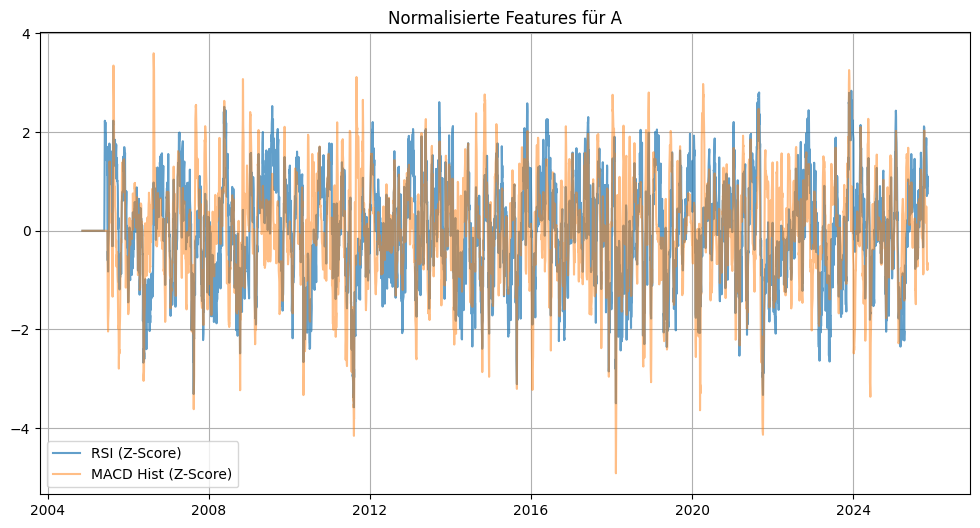

In [13]:
# =============================================================================
# PPO FEATURE ENGINEERING PIPELINE
# =============================================================================
# Features based on "Evolution of RL in Finance" Survey:
# 1. Log Returns (Immediate Performance)
# 2. Rolling Volatility (20d) -> Risk Regime
# 3. Rolling Correlation (60d) -> Diversification Potential (vs. Mean Market)
# 4. RSI (14d) -> Mean Reversion Signal
# 5. MACD Histogram -> Trend Strength
# 6. Momentum (5d, 20d) -> Mid/Long-term Trend
# =============================================================================

def calculate_rolling_z_score(series, window=252):
    """
    Normalisiert Features mit einem rollierenden Fenster (Z-Score).
    Verhindert Data Leakage (kein Blick in die Zukunft).
    """
    roll_mean = series.rolling(window=window, min_periods=window//2).mean()
    roll_std = series.rolling(window=window, min_periods=window//2).std()
    # Epsilon addieren um Division durch Null zu vermeiden
    z_score = (series - roll_mean) / (roll_std + 1e-8)
    return z_score.fillna(0) # NaNs am Anfang mit 0 füllen

print("\n--- Starte Advanced Feature Engineering ---")

# 1. Basis: Log Returns (1-Tag Momentum)
# ---------------------------------------
log_returns = np.log(price_df / price_df.shift(1)).fillna(0)
print("Feature 1: Log Returns berechnet.")

# 2. Risiko: 20-Tage Rolling Volatilität
# ---------------------------------------
# Wir nutzen Log-Returns für Volatilität, da diese additiv/stationär sind
feat_volatility = log_returns.rolling(window=20).std()
# Normalisierung: Da Volatilität immer positiv ist, hilft Z-Score dem Agenten
# zu erkennen: "Ist die Vola gerade höher als normal?"
feat_volatility_z = calculate_rolling_z_score(feat_volatility, window=252)
print("Feature 2: Rolling Volatility (20d, Z-Score) berechnet.")

# 3. Diversifikation: 60-Tage Rolling Correlation (zum 'Markt')
# -------------------------------------------------------------
# Da wir ^GSPC evtl. gelöscht haben, nutzen wir den Durchschnitt aller Assets als "Markt-Proxy"
market_proxy = log_returns.mean(axis=1)
# Berechne Korrelation jedes Assets zum Markt-Proxy
feat_correlation = log_returns.rolling(window=60).corr(market_proxy)
feat_correlation_z = feat_correlation.fillna(0) # Korrelation ist bereits zwischen -1 und 1, Z-Score optional aber gut
print("Feature 3: Rolling Correlation (60d, vs Market Mean) berechnet.")

# 4. Momentum/Reversion: RSI (14-Tage)
# ------------------------------------
try:
    # Apply TALIB RSI auf jede Spalte
    feat_rsi = price_df.apply(lambda x: talib.RSI(x.values, timeperiod=14), axis=0)
    # RSI ist 0-100. Wir skalieren es auf Z-Score oder einfach durch 100 teilen.
    # Hier: Z-Score, damit der Agent "extreme" RSI Werte deutlicher sieht.
    feat_rsi_z = calculate_rolling_z_score(feat_rsi, window=252)
    print("Feature 4: RSI (14d, Z-Score) berechnet.")
except Exception as e:
    print(f"FEHLER bei RSI Berechnung (TALIB installiert?): {e}")
    feat_rsi_z = pd.DataFrame(0, index=price_df.index, columns=price_df.columns)

# 5. Trendstärke: MACD Histogramm
# --------------------------------
# MACD (12, 26, 9) -> Wir nehmen das Histogramm (Diff zwischen MACD und Signal),
# da dieses die Trend-Stärke und -Richtung am besten komprimiert.
def get_macd_hist(series):
    macd, signal, hist = talib.MACD(series.values, fastperiod=12, slowperiod=26, signalperiod=9)
    return pd.Series(hist, index=series.index)

try:
    feat_macd = price_df.apply(get_macd_hist, axis=0)
    feat_macd_z = calculate_rolling_z_score(feat_macd, window=252)
    print("Feature 5: MACD Histogram (Z-Score) berechnet.")
except Exception as e:
    print(f"FEHLER bei MACD Berechnung: {e}")
    feat_macd_z = pd.DataFrame(0, index=price_df.index, columns=price_df.columns)

# 6. Zusatz-Momentum: Lagged Returns (5d und 20d)
# -----------------------------------------------
# Gibt dem Agenten Kontext über Wochen- und Monatstrends
feat_mom_5d = price_df.pct_change(5).fillna(0)
feat_mom_20d = price_df.pct_change(20).fillna(0)

# Z-Score Normalisierung
feat_mom_5d_z = calculate_rolling_z_score(feat_mom_5d, window=252)
feat_mom_20d_z = calculate_rolling_z_score(feat_mom_20d, window=252)
print("Feature 6: Momentum (5d & 20d, Z-Score) berechnet.")


# --- ZUSAMMENFÜHREN ---
# Wir nutzen einen MultiIndex für die Spalten, um die Features sauber zu trennen
# Struktur: [Ticker, Feature_Name]

# Liste der fertigen DataFrames
feature_frames = {
    'LogReturns': log_returns,
    'Volatility_20d': feat_volatility_z,
    'Correlation_60d': feat_correlation_z,
    'RSI_14d': feat_rsi_z,
    'MACD_Hist': feat_macd_z,
    'Momentum_5d': feat_mom_5d_z,
    'Momentum_20d': feat_mom_20d_z
}

# Zusammenfügen zu einem großen Panel (Date x (Ticker * Features))
# Dies ist effizienter für den PPO DataLoader
print("\nFüge Features zusammen...")
# Stacken um Ticker als Index zu bekommen, dann concatenaten
pieces = []
for name, df in feature_frames.items():
    # Stack bringt Ticker in den Index -> Series
    stacked = df.stack()
    stacked.name = name
    pieces.append(stacked)

# Verbinden zu einem langen DataFrame
merged_features = pd.concat(pieces, axis=1)
# Index ist jetzt (Date, Ticker). Wir wollen Ticker wieder als Spalten für das Training,
# ABER: Stable Baselines benötigt oft (Time, Features) pro Asset.
# Für Portfolio-Optimierung brauchen wir meistens: (Time, Ticker, Features).

# Wir speichern es im "Long Format" (Date, Ticker) -> Features
# Das lässt sich leicht in 3D-Tensor [Time, Assets, Features] umwandeln.
merged_features.index.names = ['Date', 'Ticker']

# Drop NaNs die durch Rolling Windows entstanden sind
# (Die ersten 60 Tage fehlen wegen Korrelation)
merged_features = merged_features.dropna()

print(f"Finale Feature-Matrix Shape: {merged_features.shape}")
print(f"Anzahl Zeilen (Tage * Ticker): {len(merged_features)}")
print(f"Features pro Asset: {merged_features.columns.tolist()}")

# =============================================================================
# ZUSATZ: MAKRO-FEATURES (VIX & US Treasury Yield)
# =============================================================================
# Wir fügen globale Markt-Daten hinzu, damit der Agent "Angst" (VIX) und
# "Zinsumfeld" (^TNX) versteht.
# =============================================================================

import yfinance as yf

print("\n--- Lade Makro-Daten (VIX & Treasury Yield) ---")

# 1. Download
# ^VIX = CBOE Volatility Index
# ^TNX = CBOE 10 Year Treasury Note Yield
macro_tickers = ['^VIX', '^TNX']
start_date_macro = price_df.index[0] # Gleicher Startzeitraum wie unsere Aktien
end_date_macro = price_df.index[-1] + pd.Timedelta(days=1)

try:
    macro_data = yf.download(macro_tickers, start=start_date_macro, end=end_date_macro)['Close']

    # 2. Bereinigung (FFill für Feiertage etc.)
    macro_data = macro_data.ffill().bfill()

    # 3. Normalisierung (Z-Score)
    # WICHTIG: VIX von 20 ist nicht das gleiche wie Return von 0.01.
    # Wir müssen das auf das gleiche Niveau bringen.
    macro_z = macro_data.apply(lambda x: calculate_rolling_z_score(x, window=252))

    # Umbenennen für Klarheit im DataFrame
    macro_z.rename(columns={'^VIX': 'Macro_VIX', '^TNX': 'Macro_US10Y'}, inplace=True)

    print("Makro-Daten geladen und normalisiert.")
    print(macro_z.tail())

    # 4. Mergen mit dem Haupt-Datensatz
    # merged_features ist im "Long Format" (Index: Date, Ticker).
    # macro_z ist im "Wide Format" (Index: Date).
    # Wir mergen auf 'Date'. Pandas broadcastet das automatisch korrekt.

    # Reset Index um 'Date' als Spalte zu haben für den Merge
    merged_reset = merged_features.reset_index()

    # Merge (Left Join, damit wir keine Zeilen verlieren)
    # Jeder Ticker an Tag X bekommt die gleichen VIX/US10Y Werte.
    merged_macro = pd.merge(merged_reset, macro_z, on='Date', how='left')

    # NaNs füllen (falls Makro-Daten Lücken hatten)
    merged_macro = merged_macro.ffill().bfill()

    # Wieder zurück in den MultiIndex (Date, Ticker)
    merged_macro.set_index(['Date', 'Ticker'], inplace=True)

    # Überschreibe das alte DataFrame
    merged_features = merged_macro

    print(f"\nERFOLG: Makro-Features hinzugefügt. Neue Shape: {merged_features.shape}")
    print(f"Features jetzt: {merged_features.columns.tolist()}")

except Exception as e:
    print(f"FEHLER beim Makro-Download: {e}")
    print("Fahre ohne Makro-Daten fort...")

# =============================================================================
# ENDE ZUSATZ
# =============================================================================

# JETZT ERST SPEICHERN (Der Teil aus dem vorherigen Code)
# merged_features.to_csv(CLEANED_FEATURES_FILE)

# Speichern
merged_features.to_csv(CLEANED_FEATURES_FILE)
print(f"\n--- ERFOLG: Feature-Set gespeichert unter: {CLEANED_FEATURES_FILE} ---")

# Kleiner Check-Plot für das erste Asset
first_ticker = price_df.columns[0]
print(f"\nBeispiel-Plot für {first_ticker} (RSI vs Price):")
plt.figure(figsize=(12, 6))
# Hole Daten für ersten Ticker aus dem MultiIndex
sample_data = merged_features.xs(first_ticker, level='Ticker')

# Plot RSI (normalisiert)
plt.plot(sample_data.index, sample_data['RSI_14d'], label='RSI (Z-Score)', alpha=0.7)
# Plot MACD (normalisiert)
plt.plot(sample_data.index, sample_data['MACD_Hist'], label='MACD Hist (Z-Score)', alpha=0.5)
plt.title(f'Normalisierte Features für {first_ticker}')
plt.legend()
plt.grid(True)
plt.show()